# Using `flax.nnx` for training


- Give them power numbers, throughput numbers, latency numbers?
- 10 Tera ops/s (can we estimate that?)
- 

In [112]:
import os
import json
from typing import Callable
import jax
import jax.numpy as jnp
from flax import nnx
from flax.nnx.nn import initializers
import optax
import matplotlib.pyplot as plt
import seaborn as sns
from HelperFunctions.binary_trident_helper_functions import *
from HelperFunctions.binary_ste import *
# from EICDense import *
# from Accumulator import *
# from PermuteBlock import *

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [113]:
# get chip params
chip_params = json.load(open('chip_params.json', 'r'))
print(chip_params)

{'rram_r_min': 25000.0, 'rram_v_in': 0.1, 'rram_num_rows': 256, 'rram_num_cols': 256, 'rram_t': 1.25e-09, 'rram_energy_per_col_op': 1.28e-12, 'ctrl_energy_per_col_op': 6.14e-14, 'comparator_energy_per_col_op': 7.68e-14, 'bus_energy_per_col_op': 1.02e-12, 'sram_static_power': 5e-06, 'cycles_per_inference': 33, 'clk_period': 1.25e-09, 'duration_per_inference': 4.125e-08, 'bits_from_pic': 1024, 'total_eic_cores': 64}


## Define a dummy module for STE in `nnx`

In [44]:
class STEParams(nnx.Module):
    """
    Define the parameters for the STE model:
    - threshold: the threshold for the nonlinearity
    - noise_sd: the standard deviation of the noise
    """
    def __init__(self, threshold, noise_sd):
        self.threshold = nnx.Param(threshold)
        self.noise_sd = nnx.Param(noise_sd)

# # create custom vjp, mark rng as nondifferentiable
# nondiff_argnums = nnx.DiffState(2, lambda _: False)

# @nnx.custom_vjp(nondiff_argnums=nondiff_argnums)
# def binary_ste(x, params, rngs):
#     threshold = params.threshold
#     noise_sd = params.noise_sd
#     rng = rngs.params()

#     # add noise
#     eps = jax.random.normal(rng, x.shape)
#     noise = eps * noise_sd
#     x_noisy = x + noise

#     # threshold: forward pass
#     y = jnp.where(x_noisy > threshold, 1.0, 0.0)

#     return y

# def binary_ste_fwd(x, params, rngs):
#     """
#     Detailed implementation to store eps and noise-free input
#     """

#     threshold = params.threshold
#     noise_sd = params.noise_sd
#     rng = rngs.params()

#     # add noise
#     eps = jax.random.normal(rng, x.shape) # reparametrization trick: noise = 0 + noise_sd * eps
#     noise = eps * noise_sd
#     x_noisy = x + noise

#     # threshold: forward pass
#     y = jnp.where(x_noisy > threshold, 1.0, 0.0)

#     return y, (x, params, eps) # x, params, eps are required to compute gradients for all learnable parameters (w.r.t. x, threshold, noise_sd)


# def binary_ste_bwd(res, g):
#     # in nnx.custom_vjp, gradients are provided as (input_updates_g, out_g)
#     input_updates_g, out_g = g
#     x_original, params, eps, rngs = res
#     noise_sd = params.noise_sd

#     # define clipping STE
#     mask = jnp.where(jnp.abs(x_original) <= noise_sd, 1.0, 0.0)

#     # gradient w.r.t. x
#     dx = mask * out_g

#     # gradient w.r.t. threshold, should also include STE but with negative sign
#     dthreshold = -out_g * mask

#     # gradient w.r.t noise_sd: 
#     dnoise_sd = out_g * mask * eps

#     # retrieve and update the gradients
#     params_updates_g = input_updates_g[1]
#     params_grad = jax.tree.map(lambda x: x, params_updates_g) # creating a copy
#     params_grad['threshold'].value = dthreshold
#     params_grad['noise_sd'].value = dnoise_sd

#     return (dx, params_grad, None) # 0 is for rngs

# binary_ste.defvjp(binary_ste_fwd, binary_ste_bwd)




In [2]:
@nnx.custom_vjp
def custom_activation(x, params, key):
    threshold = params.threshold
    noise_sd = params.noise_sd

    # add noise
    eps = jax.random.normal(key, x.shape)
    noise = eps * noise_sd
    x_noisy = x + noise

    # threshold: forward pass
    y = jnp.where(x_noisy > threshold, 1.0, 0.0)

    return y

def custom_activation_fwd(x, params, key):
    threshold = params.threshold
    noise_sd = params.noise_sd

    # add noise
    eps = jax.random.normal(key, x.shape)
    noise = eps * noise_sd
    x_noisy = x + noise

    # threshold: forward pass
    y = jnp.where(x_noisy > threshold, 1.0, 0.0)

    return y, (x, params, eps)

def custom_activation_bwd(res, g):
    x, params, eps = res
    noise_sd = params.noise_sd

    # define clipping STE
    mask = jnp.where(jnp.abs(x) <= noise_sd, 1.0, 0.0)

    # gradient w.r.t. x
    dx = mask * g

    # gradient w.r.t. threshold, should also include STE but with negative sign
    dthreshold = -g * mask

    # gradient w.r.t noise_sd: 
    dnoise_sd = g * mask * eps

    return (dx, dthreshold, dnoise_sd, None)

custom_activation.defvjp(custom_activation_fwd, custom_activation_bwd)


In [52]:
x = jnp.arange(-2, 2, 0.1)
ste_params = STEParams(threshold=0.0, noise_sd=0.1)
key = jax.random.key(0)
fwd = custom_activation(x, ste_params, key)
key, subkey = jax.random.split(key)

gr_ = nnx.vmap(nnx.grad(custom_activation), in_axes = (0, 0, None))(x, ste_params, subkey)
print(gr_)

plt.plot(x, fwd)


ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

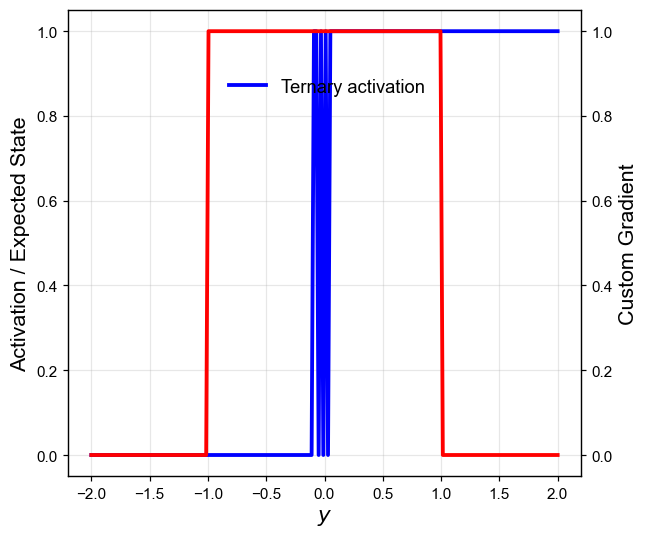

In [31]:
## testing
t = jnp.linspace(-2, 2, 200)
th = 0.0
noise_sd = 0.1
kk = jax.random.key(0)
act = binary_ste(t, th, noise_sd, kk)
cus_grad = jax.vmap(jax.grad(binary_ste), in_axes=(0, None, None, None))(t, th, noise_sd, kk)

fig, ax1 = plt.subplots(dpi = 110, figsize = (6, 5))

ax2 = ax1.twinx()
ax1.plot(t, act, c = 'b', lw = 2.5, label = "Ternary activation")
# ax1.plot(t, exp_st, lw = 2.5, label = "Expected State")
ax2.plot(t, cus_grad, c = 'r', lw = 2.5, label = r"\nabla_{\tilde{y}} \mathbb{E}[s | \tilde{y}]")
ax1.legend(loc = (0.3, 0.8), fontsize = 12, frameon = False)
ax1.grid(alpha = .3)
ax1.set_xlabel(r'$y$', fontsize = 14)
ax1.set_ylabel('Activation / Expected State', fontsize = 14)
ax2.set_ylabel('Custom Gradient', fontsize = 14)
plt.tight_layout()

## Consolidating the modules: `EICLinear`
- `EICLinear` is simply a consolidated module representing `EICDense`, `Accumulator` and `PermuteBlock` modules


## Metrics calculations

### 1. Energy
- $E_N$ : Energy per neuron
- $n_c$ : number of neurons per core
- $E_c$ : Energy per core
- $N_c$ : total number of cores required for the network.
- $E_N$ : Energy for network

$E_N = (n_c \times E_N) \times E_c \times N_c$

### 2. No. cores required:
- $L_1$ : Layer 1 size (1024)
- $L_2$ : Layer 2 size (2048)
- $L_3$ : Layer 3 size (512)
- $L_4$ : Layer 4 size (10 (256))

First compute the parameter size we need

$W_{21} \in \mathbb{R}^{2048 \times 1024}$ : Cores $\to 8 \times 4 = 32$

$W_{23} \in \mathbb{R}^{512 \times 2048}$  : Cores $\to 2 \times 8 = 16$

$W_{34} \in \mathbb{R}^{256 \times 512}$   : Cores $\to 1 \times 2 = 2$

- Total # dense cores $N_d = 32 + 16 + 1 = 49$
- Total # accumulator cores $N_a = 8 + 2 + 1 = 11$
- Total # cores needed for network $N_c = 49 + 11 = 61$
  

In [30]:
def get_num_cores(params):
    layers = params['layers']

    # compute number of cores needed
    cores_per_param = [max(l1//256, 1) * max(l2//256, 1) for l1, l2 in zip(layers[:-1], layers[1:])]
    print(cores_per_param)
    dense_cores = sum(cores_per_param)
    acc_cores = [max(l2//256, 1) for l2 in layers[1:]]
    acc_cores = sum(acc_cores)

    tot_cores = dense_cores + acc_cores # store this is return parameters

    # same a secondary metrics list
    size_metrics = {
        'dense_cores': dense_cores,
        'accumulator_cores': acc_cores,
        'total_cores': tot_cores,
    }

    return size_metrics

metric_params = {
    'layers': [1024, 2048, 512, 256], # include layer sizes
}

print(get_num_cores(metric_params))


[32, 16, 2]
{'dense_cores': 50, 'accumulator_cores': 11, 'total_cores': 61}


In [24]:
def get_energy_net(params):
    e_neuron = params['e_neuron']
    nc = params['nc']
    e_core = params['e_core']
    layers = params['layers']
    e_static = params['e_static']

    # compute number of cores needed
    cores_per_param = [max(l1//256, 1) * max(l2//256, 1) for l1, l2 in zip(layers[:-1], layers[1:])]
    print(cores_per_param)
    dense_cores = sum(cores_per_param)
    acc_cores = [max(l2//256, 1) for l2 in layers[1:]]
    acc_cores = sum(acc_cores)

    tot_cores = dense_cores + acc_cores # store this is return parameters

    # energy estimate for network
    e_net = e_core * tot_cores + e_static

    # same a secondary metrics list
    secondary_metrics = {
        'dense_cores': dense_cores,
        'accumulator_cores': acc_cores,
        'total_cores': tot_cores,
    }

    return e_net, secondary_metrics

metric_params = {
    'e_neuron': None, #J
    'nc': 256,
    'e_core': 10e-15, #J
    'layers': [1024, 2048, 512, 256],
    'e_static' : 5e-6  #W
}

e_net, sec_params = get_energy_net(metric_params)
print(e_net, sec_params)              

[32, 16, 2]
5.000000610000001e-06 {'dense_cores': 50, 'accumulator_cores': 11, 'total_cores': 61}


In [29]:
metric_params_nn2_inf = {
    'e_neuron': None, #J
    'nc': 256,
    'e_core': 10e-15, #J
    'layers': [7*7*32, 1024, 1024, 10],
    'e_static' : 5e-6  #W
}

e_net, sec_params = get_energy_net(metric_params_nn2_inf)
print(e_net, sec_params)

[24, 16, 4]
5.0000005300000004e-06 {'dense_cores': 44, 'accumulator_cores': 9, 'total_cores': 53}


In [28]:
metric_params_nn1_inf = {
    'e_neuron': None, #J
    'nc': 256,
    'e_core': 10e-15, #J
    'layers': [1024, 1024, 1024, 1024, 10],
    'e_static' : 5e-6  #W
}

e_net, sec_params = get_energy_net(metric_params_nn1_inf)
print(e_net, sec_params)

[16, 16, 16, 4]
5.00000065e-06 {'dense_cores': 52, 'accumulator_cores': 13, 'total_cores': 65}


In [2]:
## using the block module
class Block(nnx.Module):
    """Base class for accelerator circuit blocks."""
    
    def get_latency(self) -> float:
        """Returns the latency of this block (in seconds)."""
        raise NotImplementedError("Must implement a calculation for latency of"
                                  " this block.")

    def get_operations(self) -> int:
        """Returns the number of operations performed by this block (in ops)."""
        raise NotImplementedError("Must implement a calculation for number of"
                                  " operations performed by this block.")
    
    def get_energy(self) -> float:
        """Returns the energy consumption of this block (in Joules)."""
        raise NotImplementedError("Must implement a calculation for energy"
                                  " consumption of this block.")

    def __call__(self, x: jax.Array) -> jax.Array:
        """Forward pass of the block (to be implemented by subclasses).
        
            note: Block is expected to reshape its own input to the correct shape.
                e.g.: x = x.reshape(self.input_shape)
        """
        raise NotImplementedError("Must implement a forward pass for this block.")
    
    def __getitem__(self, key: str):
        """Syntactic sugar to call the latency, operations, or energy methods
            useful for traversing the connection tree for various calculations.
        """
        if key == "latency":
            return self.get_latency()
        elif key == "operations" or key == "ops":
            return self.get_operations()
        elif key == "energy":
            return self.get_energy()
        else:
            raise KeyError(f"Indexing key {key} not supported.")

## Converting EICDense to `nnx.Module`

In [3]:
class EICDense(nnx.Module):
    """
    Pseudo-dense layer using EIC Cores.
    Args:
    in_size: int, number of input neurons
    out_size: int, number of output neurons
    threshold: float, threshold for binary activation
    noise_sd: flaat, standard deviation of noise for binary activation
    key: jax.random.PRNGKey, random key

    Returns:
    x: jnp.ndarray, output of the layer
    """

    def __init__(self, in_size, out_size, key):
        self.in_size = in_size
        self.out_size = out_size

        # initialize the number of cores required
        self.in_blocks = in_size // 256
        self.out_blocks = out_size // 256
        self.num_cores = self.in_blocks * self.out_blocks

        # initialize the core weights
        # weights reshaped as (out_blocks, in_blocks, 256, 256)y
        # assumes that input is shaped as (batch_size, in_blocks, 256)
        glorot_initializer = initializers.glorot_normal()
        self.cores = nnx.Param(glorot_initializer(key, (self.out_blocks, self.in_blocks, 256, 256)))


    def __call__(self, x):
        """
        Forward pass of the layer
        Args:
        x: jnp.ndarray (batch_size, in_size), input to the layer
        
        Returns:
        x: jnp.ndarray, output of the layer
        """

        assert x.shape[-1] == self.in_size, f"Input shape is incorrect. Got {x.shape[-1]}, expected {self.in_size}"

        x_reshaped = x.reshape(x.shape[0], self.in_blocks, 256) # organize x into blocks of 256 for every batch

        # make sure that the weights are positive
        self.cores = jax.nn.softplus(self.cores)

        y = jnp.einsum("ijkl,bjl->bijk", self.cores, x_reshaped)

        # quantize weights
        # W_pos = quantize_params(W_pos, bits = 8)

        return y
    
# test
key = jax.random.key(123124)
ed = EICDense(in_size = 1024, out_size = 2048, key = key)
x = jax.random.normal(key, (10, 1024))*0.01
y = ed(x)
print(y.shape)
print(ed.cores.shape)

(10, 8, 4, 256)
(8, 4, 256, 256)


## Converting Accumulator to `nnx.Module`

(10, 2048)
(8, 256, 256)


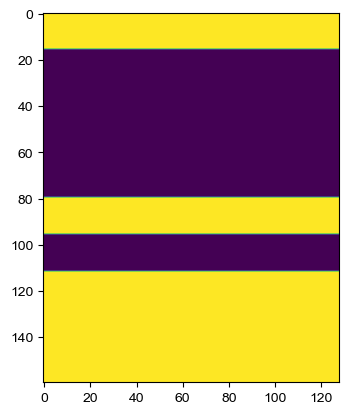

In [4]:
# define the accumulator module
class Accumulator(nnx.Module):
    """
    Accumulating the EICDense outputs. 
    Since the EICDense generates pseudo-feedforward outputs, we use a learnable accumulation matrix that minimizes error
    between the true feedforward output and the EIC output.

    Args:
        in_block_size: int, number of 256-sized blocks. This should be the .shape[0] of the EICDense output
    """

    def __init__(self, out_size, key):

        # this should be the same as the number of output blocks from the EICDense
        self.out_block = out_size//256

        # set up the params
        glorot_initializer = initializers.glorot_normal()
        self.acc_cores = nnx.Param(glorot_initializer(key, (self.out_block, 256, 256)))



    def __call__(self, x):
        """
        Forward pass of the accumulator
        Args:
        x: jnp.ndarray, input to the accumulator
        
        Returns:
        x: jnp.ndarray, output of the accumulator
        """

        assert x.shape[1] == self.out_block, f"Input shape is incorrect. Got {x.shape[1]}, expected {self.out_block}"
        # assert x.shape[1] == self.out_block_size, "Input shape is incorrect"

        # ensure positive 
        self.acc_cores = jax.nn.softplus(self.acc_cores)
        # W_pos = quantize_params(W_pos, bits = 8)
        
        x = jnp.einsum("bijk->bik", x)
        y = jnp.einsum("ijk,bik->bik", self.acc_cores, x) 

        # flatten y before returning
        y = y.reshape((y.shape[0], -1)) # (batch_size, out_size)

        return y

# test
acc = Accumulator(out_size = 2048, key = key)
y_acc = binary_ste(acc(y), threshold = 0.0, noise_sd = 5e-2, key = key)
plt.imshow(y_acc.reshape(-1, 128))
print(y_acc.shape)
print(acc.acc_cores.shape)


## Converting PermuteBlock to `nnx.Module`

(10, 2048)
PermuteBlock(
  input_size=2048,
  permute_block_size=16,
  core_input_size=256,
  num_slots=16,
  num_subvectors=8,
  tau=Param(
    value=1.0
  ),
  Ppos=Array(shape=(16, 16), dtype=float32),
  Pneg=Array(shape=(16, 16), dtype=float32)
)


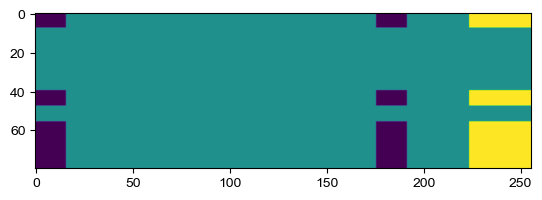

In [42]:
class PermuteBlock(nnx.Module):
    """
    Contains two fixed permutation matrices (pos and neg) to shuffle the input block-wise.
    This block should be used at the beginning of the pipeline so that balanced inputs are fed into the EICDense/
    """

    def __init__(self, 
                 input_size: int
                 ):
        
        # define permutation axes
        self.input_size = input_size
        self.permute_block_size = 16
        self.core_input_size = 256
        self.num_slots = self.core_input_size // self.permute_block_size # should be 16 in the latest iteration
        self.num_subvectors = self.input_size // self.core_input_size # for input_size = 1024, should be 4

        # initialize the temperature parameter
        self.tau = nnx.Param(1.0)

        # generate two independent permutation sequences
        key = jax.random.key(1245)
        key1, key2 = jax.random.split(key)
        p1 = jax.random.permutation(key1, self.num_slots)
        p2 = jax.random.permutation(key2, self.num_slots) # jnp.roll(p1, shift = 1) #

        # generate permutation matrices
        m1 = jnp.eye(self.num_slots)*self.tau
        m2 = jnp.eye(self.num_slots)*self.tau

        # generate the permutation matrices
        self.Ppos = m1[p1]
        self.Ppos = jax.nn.softmax(self.Ppos, axis = -1)
        self.Pneg = m2[p2]
        self.Pneg = jax.nn.softmax(self.Pneg, axis = -1)

    def __call__(self, x: jax.Array) -> jax.Array:
        """
        Apply permutations and return (xpos - xneg)
        Args:
        x: jnp.ndarray, input vector. Shape: (batch_size, input_size) e.g. (32, 2048)
        Returns:
        xpos - xneg: jnp.ndarray, difference of permuted inputs. Shape: (batch_size, input_size)
        """

        assert x.shape[-1] == self.input_size, f"Input shape is incorrect. Got {x.shape[-1]}, expected {self.input_size}"
        assert self.num_subvectors * self.num_slots * self.permute_block_size == self.input_size, f"Inconsistent metrics!"

        x = x.reshape(x.shape[0], self.num_subvectors, self.num_slots, self.permute_block_size) # first dimension must be the batch size

        xpos = jnp.einsum('ij,bsjp->bsip', self.Ppos, x)
        xneg = jnp.einsum('ij,bsjp->bsip', self.Pneg, x)

        xout = xpos - xneg

        xout = xout.reshape((x.shape[0], self.input_size))

        return xout
    
# test
per = PermuteBlock(input_size = 2048)
y_per = per(y_acc)
plt.imshow(y_per.reshape(-1, 256))
print(y_per.shape)
# print(per.acc_cores.shape)
# print(jax.tree.map(jnp.shape, nnx.state(per, nnx.Param)))
nnx.display(per)

In [6]:
## trying out a simple linear block
class LinearBlock(Block):
    """
    Simple linear block to test out block module from PIC
    """

    def __init__(self, in_size, out_size, rng):
        self.in_size = in_size
        self.out_size = out_size
        self.kernel = nnx.Param(jax.random.normal(rng, (out_size, in_size)))
        self.bias = nnx.Param(jax.random.normal(rng, (out_size,)))

    def get_latency(self):
        return -1
    
    def get_energy(self):
        return -1
    
    def get_operations(self):
        return -1
    
    def __call__(self, x):
        return jnp.einsum('ij,j->i', self.kernel, x) + self.bias
    
lin1 = LinearBlock(10, 5, jax.random.key(1))


(10, 2048)


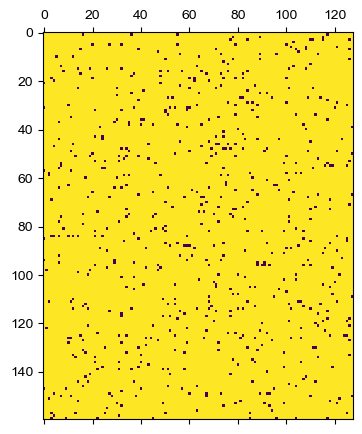

In [10]:
class EICLinear(nnx.Module):
    """
    Consolidated EICLinear block
    """

    def __init__(self,
                 in_size: int, # size of input layer
                 out_size: int, # size of the output layer
                 eic_activation_fn: Callable, # EICDense activation function
                 acc_activation_fn: Callable, # Accumulator activation function
                 key: jax.random.key, # PRNG key
                 threshold: float = 0.0, # threshold for binary activation
                 noise_sd: float = 0.05 # standard deviation of noise for binary activation 
                 ):
        self.in_size = in_size
        self.out_size = out_size
        self.eic_activation_fn = eic_activation_fn
        self.acc_activation_fn = acc_activation_fn
        self.key = key
        self.threshold = threshold
        self.noise_sd = noise_sd

        # self.in_blocks = self.in_size//256
        # self.out_blocks = self.out_size//256

        # define the three blocks
        key, subkey = jax.random.split(self.key)
        self.eic_dense = EICDense(self.in_size, self.out_size, key)
        key, subkey = jax.random.split(key)
        self.accumulator = Accumulator(self.out_size, subkey)
        key, subkey = jax.random.split(key)
        self.permute = PermuteBlock(self.in_size)
        
    def __call__(self, x):
        """
        Forward pass of EICLinear block.
        Order of operations: input (x) -> PermuteBlock -> EICDense -> Accumulator 
        Ensure that:
          - before arriving to this module, there is a conv layer -> PermuteBlock. Otherwise, before the first layer add a PermuteBlock
        Args:
         - x: jax.Array, input vector, typically flattened image etc.
        Returns:
            - x: jax.Array, output of the EICLinear block
        """

        x = self.permute(x)
        x = self.eic_dense(x)
        key, subkey = jax.random.split(self.key)
        x = self.eic_activation_fn(x, threshold = self.threshold, noise_sd = self.noise_sd, key = subkey)
        x = self.accumulator(x)
        key, subkey = jax.random.split(key)
        x = self.acc_activation_fn(x, threshold = self.threshold, noise_sd = self.noise_sd, key = subkey)

        return x
        
# test
key = jax.random.key(123124)
eic_lin = EICLinear(in_size = 1024, out_size = 2048, eic_activation_fn = binary_ste, acc_activation_fn = binary_ste, key = key)
x = jax.random.normal(key, (10, 1024))*0.001
y = eic_lin(x)
print(y.shape)
plt.matshow(y.reshape(-1, 128))


## Pilot `EICNetwork` Module

In [132]:
class EICNetwork(Block):
    """
    - Contains the current best, EIC-mappable architecture for the network.
    - For independent training of block, the first layer is asomed to be a usual conv layer. This can for example, be replaced with the PIC-end input.
    - Note that I'm including custom functions for linear, relu and sigmoid. They keep the same signature as the binary_ste function.
    - In case the binary stochastic activation implemented with binary_ste fails to train, we can use sigmoid for now and later replace it with a custom activation function.
    - The EICNetwork is a sequence of EICLinear blocks.

    * Architecture:
    - Pseudo-Feedforward layer: Mathematical approximation of a feedforward layer implemented using constraints of the EIC core.
    - Initial conv + avg pool takes (batch_size, 32, 32, 1) image and converts it to (batch_size, 16, 16, 1) tensor which is then resized to (batch_size, 256).
    - Layer sizes: 256 -> 2048 -> 512 -> 256 (10).
    - NOTE: This architecture is a bit different on the input layer (excel sheet has 1024) because I absorbed the 1024 in conv layer just for reference to NN2. This only changes throughput.
    - Activation: Binary with gradient clipping straight-through estimator. In case of low performance, we might tweak the STE.
    """

    @staticmethod
    def linear_activation(x, threshold = None, noise_sd = None, key = None):
        return x
    
    @staticmethod
    def relu_activation(x, threshold = None, noise_sd = None, key = None):
        """
        In case the binary activation doesn't work, we can use a ReLU activation
        """
        return jax.nn.relu(x)
    
    @staticmethod
    def sigmoid_activation(x, threshold = None, noise_sd = None, key = None):
        """
        In case the binary activation doesn't work, we can use a sigmoid activation
        """
        return jax.nn.sigmoid(x)

    def __init__(self, 
                layer_sizes: list, # list of feedforward layer sizes e.g. [1024, 2048, 512, 256]
                eic_activation_fn: Callable, # EICDense activation function
                acc_activation_fn: Callable, # Accumulator activation function
                key: jax.random.key, # PRNG key
                chip_params: dict = None # dictionary of chip parameters
                ):
        
        """
        Args:
        - layer_sizes: list, list of feedforward layer sizes e.g. [1024, 2048, 512, 256]
        - eic_activation_fn: Callable, EICDense activation function
        - acc_activation_fn: Callable, Accumulator activation function
        - key: jax.random.key, PRNG key
        - chip_params: dict, dictionary of chip parameters
        """
        
        self.layer_sizes = layer_sizes
        self.eic_activation_fn = eic_activation_fn
        self.acc_activation_fn = acc_activation_fn
        self.key = key
        self.chip_params = chip_params

        # define the layers
        self.first_layers = [EICLinear(in_size = in_size, 
                                 out_size = out_size, 
                                 eic_activation_fn = self.eic_activation_fn, 
                                 acc_activation_fn = self.acc_activation_fn, 
                                 key = self.key) 
                                 for in_size, out_size in zip(self.layer_sizes[:-1], self.layer_sizes[1:-1])]
        
        self.last_layer = EICLinear(
            in_size = self.layer_sizes[-2],
            out_size = self.layer_sizes[-1],
            eic_activation_fn = self.eic_activation_fn,
            acc_activation_fn = self.linear_activation,
            key = self.key
        )

        self.conv = nnx.Conv(in_features=1, out_features=1, kernel_size=(3,3), strides=1, padding=1, rngs=nnx.Rngs(params=1134, dropout=78978))

    def __call__(self, x: jax.Array) -> jax.Array:
        """
        Forward pass of the EICNetwork.
        Order of operations: Conv -> AvgPool -> EICLinear layers
        Args:
            - x: jax.Array, input vector, typically flattened image etc.
        Returns:
            - x: jax.Array, output of the EICNetwork
        """

        # Resize input to (batch_size, 32, 32, 1): emulating the 1024-long input that we anticipate
        x = jax.image.resize(x, shape=(x.shape[0], 32, 32, 1), method="bilinear")
        print(x.shape)

        # Apply dummy convolution and average pooling
        x = self.conv(x)
        x = nnx.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID') 
        
        # Flatten the output to match the input size of the first linear layer
        x = x.reshape(x.shape[0], -1)

        print(x.shape)

        # apply EIC layers
        for layer in self.first_layers:
            x = layer(x)

        x = self.last_layer(x)           
        
        return x
    
    def get_num_cores(self):
        layers = self.layer_sizes

        # compute number of cores needed
        cores_per_param = [max(l1//256, 1) * max(l2//256, 1) for l1, l2 in zip(layers[:-1], layers[1:])]
        dense_cores = sum(cores_per_param)
        acc_cores = [max(l2//256, 1) for l2 in layers[1:]]
        acc_cores = sum(acc_cores)

        tot_cores = dense_cores + acc_cores # store this is return parameters

        # same a secondary metrics list
        size_metrics = {
            'dense_cores': dense_cores,
            'accumulator_cores': acc_cores,
            'total_cores': tot_cores,
        }

        return size_metrics


    def get_latency(self):
        """
        Returns latency of the EIC network in ns
        Requires the chip parameters to be defined in the chip_params dictionary.
        """

        # duration_per_inference = 4.13e-8 # s
        num_layers = len(self.layer_sizes) # number of layers in the network
        # print(f"Number of layers: {num_layers}")
        latency = (chip_params['duration_per_inference'] * (1 + num_layers))*1e9
        print(f"Latency in ns: {latency}")
        return latency
    
    def get_energy(self):
        """
        Estimates the energy consumption of the proposed network in TOP/J
        Requires the chip parameters to be defined in the chip_params dictionary.
        """
        num_cores = self.get_num_cores()
        num_cores = num_cores['total_cores']
        col_ops_per_inference = num_cores * chip_params['rram_num_cols']
        energy_per_inference = col_ops_per_inference * (chip_params['rram_energy_per_col_op'] + chip_params['ctrl_energy_per_col_op'] + chip_params['comparator_energy_per_col_op'] + chip_params['bus_energy_per_col_op']) + chip_params['sram_static_power']*chip_params['duration_per_inference']
        ops_per_inference = col_ops_per_inference*chip_params['rram_num_rows']
        # print(f"Ops per inference: {ops_per_inference}")
        energy = (energy_per_inference*1e3)/ops_per_inference * 1e12 # TOP/J
        print(f"Energy in TOP/J: {energy}")
        return energy
    
    def get_operations(self):
        """
        Returns throughput in TOPS/s
        Requires the chip parameters to be defined in the chip_params dictionary.
        """
        num_cores = self.get_num_cores()
        num_cores = num_cores['total_cores']
        # print(f"Number of cores: {num_cores}")
        col_ops_per_inference = num_cores * chip_params['rram_num_cols']
        ops_per_inference = col_ops_per_inference*chip_params['rram_num_rows']
        # print(f"Operations per inference: {ops_per_inference}")
        duration_per_inference = chip_params['duration_per_inference']
        throughput = ops_per_inference/duration_per_inference * 1e-12 # TOPS/s
        print(f"Throughput in TOPS/s: {throughput}")
        return throughput

(10, 32, 32, 1)
(10, 256)
(10, 256)
[[355.32996 357.4664    0.      ...   0.      177.14598 178.0308 ]
 [177.66498 178.7332  355.33353 ... 177.8121  177.14598 178.0308 ]
 [177.66498 178.7332  177.66676 ... 355.6242  354.29196 356.0616 ]
 ...
 [355.32996   0.        0.      ...   0.      177.14598 356.0616 ]
 [355.32996   0.      177.66676 ... 355.6242  354.29196   0.     ]
 [  0.        0.      177.66676 ... 355.6242  177.14598 356.0616 ]]


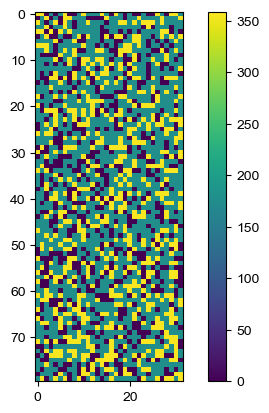

In [133]:
im_ = jnp.ones((10, 28, 28, 1))
eic_net = EICNetwork(layer_sizes = [256, 2048, 512, 256], eic_activation_fn = binary_ste, acc_activation_fn = binary_ste, key = key, chip_params = chip_params)
out_ = eic_net(im_)
print(out_.shape)
print(out_)
plt.imshow(out_.reshape(-1, 32))
plt.colorbar()

In [134]:
lat = eic_net.__getitem__("latency")
ene = eic_net.__getitem__("energy")
thr = eic_net.__getitem__("operations")


Latency in ns: 206.25
Energy in TOP/J: 9.524303807439031
Throughput in TOPS/s: 58.783806060606054


In [82]:
4.13 * 5

20.65

## Chip parameters dictionary

In [110]:
rram_r_min = 2.50e4  # Ohm
rram_v_in = 0.1  # V
rram_num_rows = 256
rram_num_cols = 256
rram_t = 1.25e-9  # s
rram_energy_per_col_op = rram_v_in/(rram_r_min/rram_num_cols)*rram_t #J
ctrl_energy_per_col_op = 6.14e-14 #J
comparator_energy_per_col_op = 7.68e-14 #J
bus_energy_per_col_op = 1.02e-12 #J
sram_static_power = 5e-6 #W
cycles_per_inference = 8 * 4 + 1
clk_period = 1.25e-9
duration_per_inference = cycles_per_inference * clk_period
bits_from_pic = 1024 # assumption
total_eic_cores = 64 # subjcet to change


print(f"rram energy per col op: {rram_energy_per_col_op} J")
print(f"duraion per inference: {duration_per_inference} s")



rram energy per col op: 1.28e-12 J
duraion per inference: 4.125e-08 s


In [111]:
chip_params = {
    'rram_r_min': rram_r_min,  # Ohm
    'rram_v_in': rram_v_in,  # V
    'rram_num_rows': rram_num_rows,
    'rram_num_cols': rram_num_cols,
    'rram_t': rram_t,  # s
    'rram_energy_per_col_op': rram_energy_per_col_op,  # J
    'ctrl_energy_per_col_op': ctrl_energy_per_col_op,  # J
    'comparator_energy_per_col_op': comparator_energy_per_col_op,  # J
    'bus_energy_per_col_op': bus_energy_per_col_op,  # J
    'sram_static_power': sram_static_power,  # W
    'cycles_per_inference': cycles_per_inference,
    'clk_period': clk_period,
    'duration_per_inference': duration_per_inference,  # s
    'bits_from_pic': bits_from_pic,  # assumption
    'total_eic_cores': total_eic_cores  # subject to change
}

# print(chip_params)

# with open('chip_params.json', 'w') as file:
#     json.dump(chip_params, file)


# random Testing

In [63]:
im_ = jnp.ones((10, 32, 32, 1))
c = nnx.Conv(in_features = 1, out_features = 1, kernel_size = (4,4), strides = 2, padding = 3, rngs = nnx.Rngs(params = 1))
im_ = c(im_)
im_ = nnx.avg_pool(im_, window_shape = (2, 2), strides = (1, 1), padding = 'SAME')
print(im_.shape)

(10, 18, 18, 1)


In [39]:
ll = [1024, 2048, 512, 256]

siz = [(lo, li) for lo, li in zip(ll[:-1], ll[1:-1])]
print(siz)

[(1024, 2048), (2048, 512)]


In [67]:
im_ = jnp.ones((10, 32, 32, 1))
c2 = nnx.Conv(in_features=1, out_features=1, kernel_size=(3,3), strides=1, padding=1, rngs=nnx.Rngs(params=1))

im2 = c2(im_)

# Now downsample using avg pooling
im2 = nnx.avg_pool(im2, window_shape=(2, 2), strides=(2, 2), padding='VALID') 

print(im2.shape)

(10, 16, 16, 1)
